<a href="https://colab.research.google.com/github/malekkhaled/Machine_Learning/blob/main/Toronto%20Clustering/Clustering_Neighborhoods_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all libraries needed

In [103]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup


<b>Use Beautiful Soup packge to scrape our wikipedia page.</b>
<br>Going through each td element we store the postal code, Borough, and Neighbourhood in a list of dictionaries and then transform it to a pandas dataframe.


In [104]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

table_contents=[]
table=soup.find('table')

for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


Getting the number of rows and columns in our dataframe.

In [105]:
df.shape

(103, 3)

In [106]:
df_coord = pd.read_csv('/content/Geospatial_Coordinates.csv')
df_coord

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [107]:
neighborhoods = pd.merge(df, df_coord, left_on='PostalCode', right_on='Postal Code').drop(columns=['Postal Code'])

In [108]:
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [109]:
from sklearn.cluster import KMeans
import folium 

In [110]:
from geopy.geocoders import Nominatim
address = "Toronto, Canada"
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [111]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
        
folium.TileLayer('Stamen Terrain').add_to(map_Toronto)
folium.TileLayer('Stamen Toner').add_to(map_Toronto)
folium.TileLayer('Stamen Water Color').add_to(map_Toronto)
folium.TileLayer('cartodbpositron').add_to(map_Toronto)
folium.TileLayer('cartodbdark_matter').add_to(map_Toronto)
folium.LayerControl().add_to(map_Toronto)    
map_Toronto

Github does not show maps so I had to include an image of it.

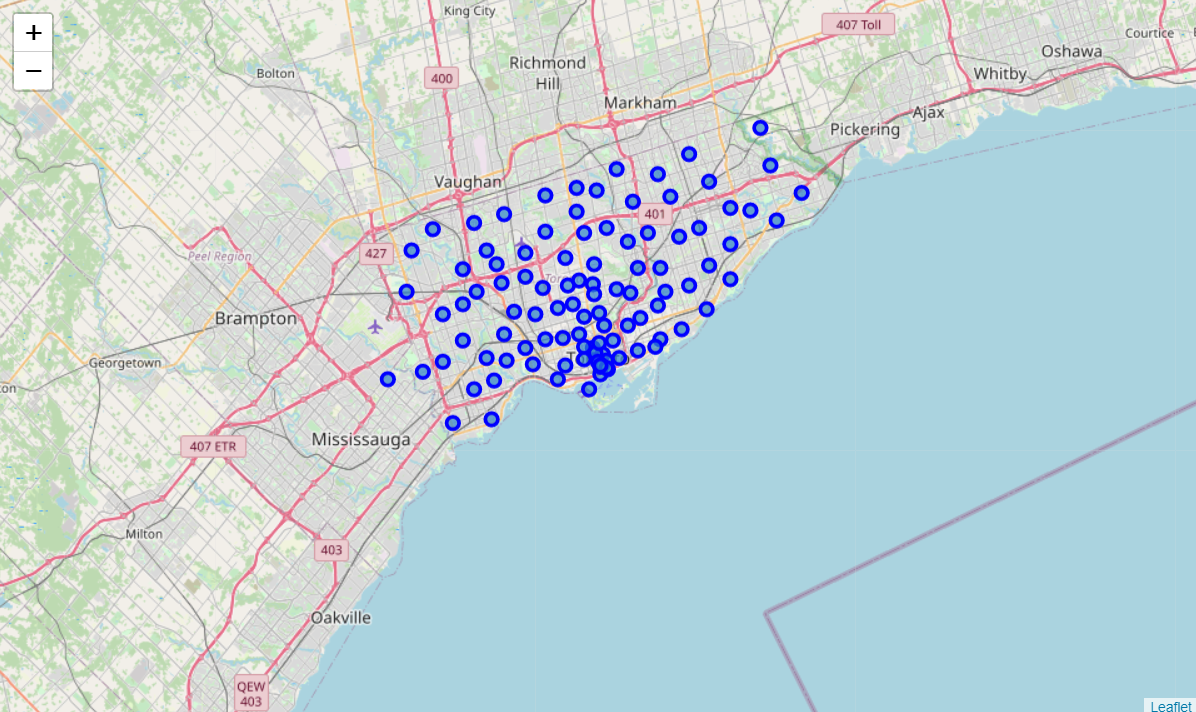

In [112]:
CLIENT_ID = '4JJMG3E5NIOI14QZJNZF5TDSFBFW5MIPCRMXIN5K0PL2VXR2' 
CLIENT_SECRET = 'DJJIM2CK4E4513TRXXGUDGK1OEHE3A2T5LB3YGKK1SU0ZE4M' 
VERSION = '20180605' 
LIMIT = 100

In [113]:
for name, lat, lng in zip(neighborhoods['Neighborhood'],neighborhoods['Latitude'],neighborhoods['Longitude']):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '610aca5bfff1a46a21107ebf'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4b5fcadff964a520eecc29e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/wings_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d14c941735',
         'name': 'Wings Joint',
         'pluralName': 'Wings Joints',
         'primary': True,
         'shortName': 'Wings'}],
       'id': '4b5fcadff964a520eecc29e3',
       'location': {'address': '1000 Islington Ave',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'crossStreet': 'at Titan Rd',
        'distance': 278,
        'formattedAddress': ['1000 Islington Ave (at Titan Rd)',
         'Toronto ON M8Z 4P8',
         'Canada'],
        'labeledLatLngs': [{'l

In [114]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [115]:
Toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'])


Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [116]:
Toronto_venues.shape

(2153, 7)

In [117]:
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [118]:
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

Toronto_onehot = Toronto_onehot.set_index('Neighborhood')
Toronto_onehot = Toronto_onehot.reset_index()
Toronto_onehot


,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,...,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2149,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2150,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2151,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [119]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').count()
Toronto_grouped

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,...,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agincourt,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
"Alderwood, Long Branch",9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Willowdale West,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
"Willowdale, Newtonbrook",2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Woburn,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [120]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,...,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,"Willowdale, Newtonbrook",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.

In [121]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [122]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Chinese Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
1,"Alderwood, Long Branch",Pizza Place,Playground,Pub,Coffee Shop,Pool,Pharmacy,Gym,Sandwich Place,Electronics Store,Escape Room
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Frozen Yogurt Shop,Shopping Mall,Sandwich Place,Diner,Middle Eastern Restaurant,Supermarket,Restaurant
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Hobby Shop,Italian Restaurant,Coffee Shop,Pizza Place,Butcher,Café,Restaurant,Pub,Pharmacy


In [123]:
from sklearn.cluster import KMeans

kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = neighborhoods

Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Fast Food Restaurant,Park,Food & Drink Shop,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Escape Room
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Coffee Shop,Financial or Legal Service,Hockey Arena,Portuguese Restaurant,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Yoga Studio,Chocolate Shop,Bank
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Accessories Store,Furniture / Home Store,Clothing Store,Coffee Shop,Shoe Store,Miscellaneous Shop,Gift Shop,Boutique,Vietnamese Restaurant,Creperie
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,0.0,Coffee Shop,Café,Diner,Yoga Studio,Bank,Sushi Restaurant,Bar,Distribution Center,Italian Restaurant,Portuguese Restaurant


In [124]:
Toronto_merged['Cluster Labels'] = pd.to_numeric(Toronto_merged['Cluster Labels'], errors='coerce')
Toronto_merged = Toronto_merged.dropna(subset=['Cluster Labels'])
Toronto_merged['Cluster Labels'] = Toronto_merged['Cluster Labels'].astype(int)


In [125]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

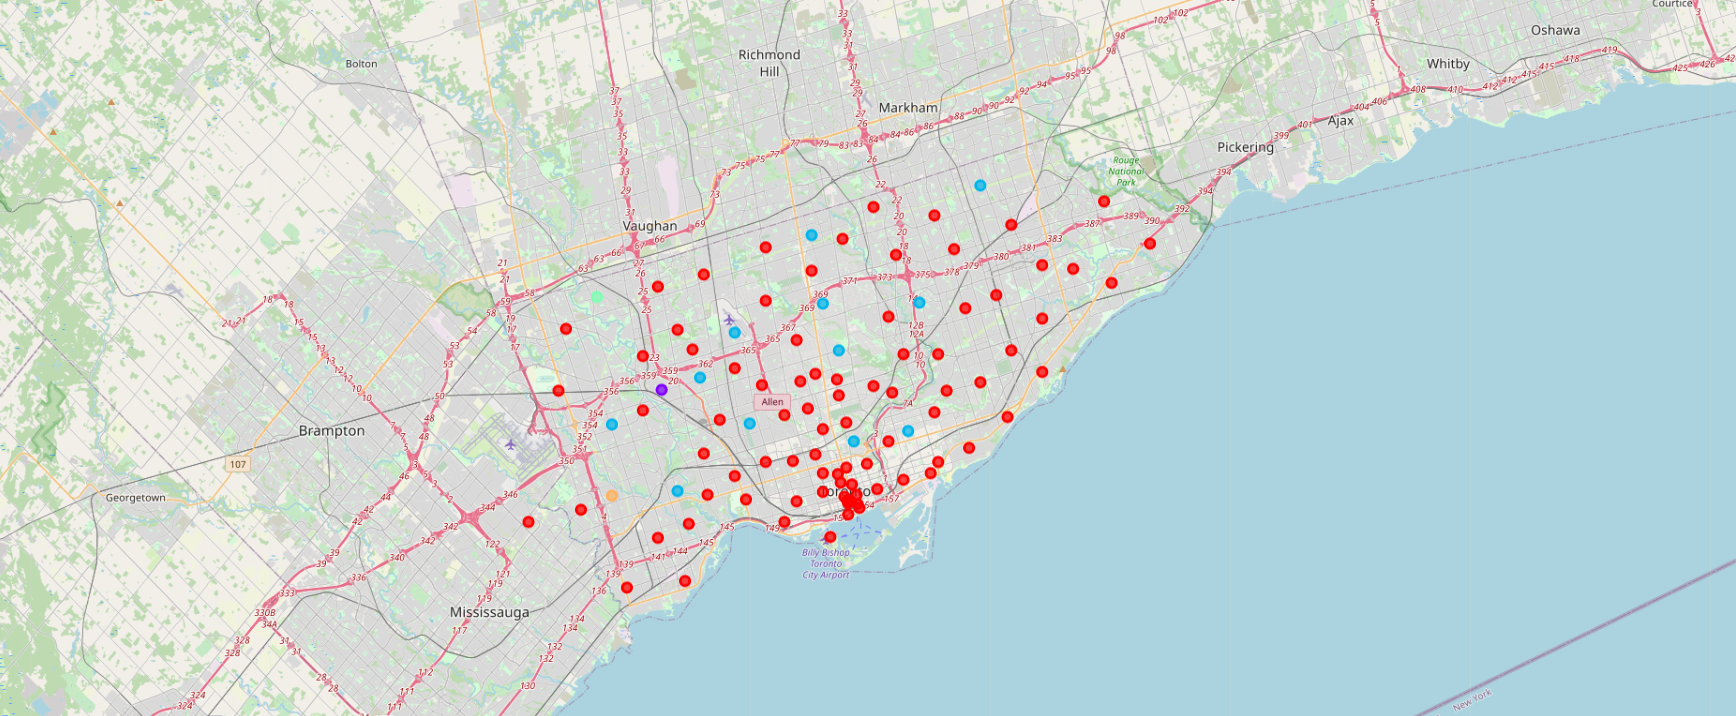